In [1]:
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4
SPEED_THRESHOLD = 200

## Load and Prepare Formula 1 Race Sessions

In [2]:
year = 2025

schedule = fastf1.get_event_schedule(year)
gp_events = schedule[schedule['EventName'].str.contains("Grand Prix")]['EventName'].tolist()
gp_events = schedule[
    (schedule['EventName'].str.contains("Grand Prix")) &
    (schedule['EventDate'] <= datetime.datetime.now())
]['EventName'].tolist()

sessions = {}

def load_session(event):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(load_session, e): e for e in gp_events}
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            event, session = result
            sessions[event] = session

core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	

## Compute Cornering and Telemetry Metrics for Each Race

In [3]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[event]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

## Visualize Telemetry Data and Cornering Events

In [4]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"{event}_isCorner.png")
    plt.close()

## Extract Driver Lap Statistics and Telemetry Metrics

In [5]:
df = pd.DataFrame()
rows = []

def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

for event in gp_events:
    session = sessions[event]
    for num in session.drivers:
        driver = session.get_driver(num)['Abbreviation']
        team = session.get_driver(num)['TeamName']

        driver_laps = session.laps.pick_driver(driver)
        if driver_laps.empty:
            continue

        lap_median = pick_median(driver_laps)
        lap_fastest = driver_laps.pick_fastest()
        if lap_median is None or lap_fastest is None: continue
        tel_median = lap_median.get_car_data()
        tel_fastest = lap_fastest.get_car_data()

        corner_speeds = tel_median.query('Speed < 200')['Speed']
        straight_speeds = tel_median.query('Speed >= 200')['Speed']

        rows.append(
            {
                "Driver": driver,
                "Team": team,
                "Event": event,
                "TyreCompound": lap_fastest['Compound'] if 'Compound' in lap_fastest else None,
                "Qualifying Time": lap_fastest['LapTime'].total_seconds() if lap_fastest['LapTime'] else None,
                "Top Speed": tel_median['Speed'].max(),
                "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                "ThrottleMean": tel_median['Throttle'].mean(),
                "ThrottleStdDev": tel_median['Throttle'].std(),
                "BrakeMean": tel_median['Brake'].mean(),
                "BrakeStdDev": tel_median['Brake'].std(),
                "DRSMean": tel_median['DRS'].mean()
            }
        )

        # weather = session.weather_data
        # df.at[i, 'AirTemp'] = weather['AirTemp'].mean()
        # df.at[i, 'TrackTemp'] = weather['TrackTemp'].mean()
        # df.at[i, 'Humidity'] = weather['Humidity'].mean()
        # df.at[i, 'Pressure'] = weather['Pressure'].mean()
        # df.at[i, 'Rainfall'] = weather['Rainfall'].mean()

df = pd.DataFrame(rows)

In [6]:
df.to_csv('f1.csv', index = False)

## Assess Multicollinearity in Telemetry Features

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)

continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("Qualifying Time")

# Check VIF (Multicolinearity)
formula = f'Q("Qualifying Time") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable          VIF
0                    Intercept  6290.555535
1               Q("Top Speed")     6.259482
2          Q("AvgCornerSpeed")     2.740664
3     Q("AvgCornerEntrySpeed")     1.142872
4      Q("AvgCornerExitSpeed")     1.120831
5        Q("AvgStraightSpeed")     7.061505
6   Q("AvgStraightEntrySpeed")    15.019837
7    Q("AvgStraightExitSpeed")    12.498465
8            Q("ThrottleMean")     7.137255
9          Q("ThrottleStdDev")     2.113944
10              Q("BrakeMean")    66.629779
11            Q("BrakeStdDev")    65.775044
12                Q("DRSMean")     1.810409


In [8]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("BrakeStdDev")
continuous_columns.remove("AvgStraightExitSpeed")
continuous_columns.remove("AvgStraightSpeed")

formula = f'Q("Qualifying Time") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                     variable          VIF
0                   Intercept  2529.499956
1              Q("Top Speed")     3.241166
2         Q("AvgCornerSpeed")     1.990485
3    Q("AvgCornerEntrySpeed")     1.067263
4     Q("AvgCornerExitSpeed")     1.074703
5  Q("AvgStraightEntrySpeed")     1.646552
6           Q("ThrottleMean")     5.468378
7         Q("ThrottleStdDev")     1.625838
8              Q("BrakeMean")     3.039454
9                Q("DRSMean")     1.688091


## Build and Evaluate Machine Learning Models

### Linear Regression

In [9]:
x = df.drop(columns=['Qualifying Time', 'BrakeStdDev'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df[['Qualifying Time']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

y_pred = model_lm.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-Squared: {r2}")
print(f"RMSE: {rmse}")

R-Squared: 0.984387436064165
RMSE: 1.3543820054420703


### Random Forest Regressor

In [10]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(1, 51)),
              'min_samples_leaf': list(range(1, 5))
              }

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_rf.fit(x_train, y_train)

print("Best params:", grid_search_rf.best_params_)
# print("Train RMSE:", -grid_search.best_score_)

best_rf = grid_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Test R-Squared: {r2}")
print(f"Test RMSE: {rmse}")

# importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'min_samples_leaf': 2, 'n_estimators': 43}
Test R-Squared: 0.9653440774826286
Test RMSE: 2.0178681805485605


### XGBoost Regressor

In [11]:
import xgboost as xgb

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": [350, 375, 400],
              "learning_rate": [0.01, 0.05, 0.1]
              }

grid_search_xgb = GridSearchCV(
    estimator=xg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_xgb.fit(x_train, y_train)

print("Best params:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_

y_pred = grid_search_xgb.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-Squared: {r2}")
print(f"RMSE: {rmse}")

# importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'learning_rate': 0.05, 'n_estimators': 400}
R-Squared: 0.9875640869140625
RMSE: 1.208767944760905


### Naive Bayes Classifier

Accuracy:  0.5652173913043478
Predicted  fast  medium  slow
Actual                       
slow          2       0    16
medium        8      15     6
fast          8       7     7


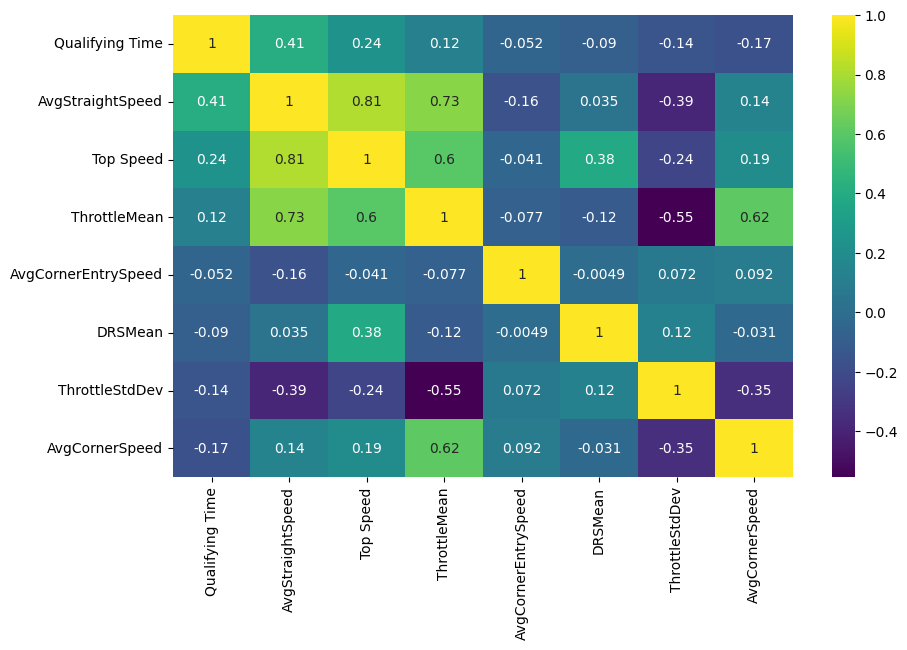

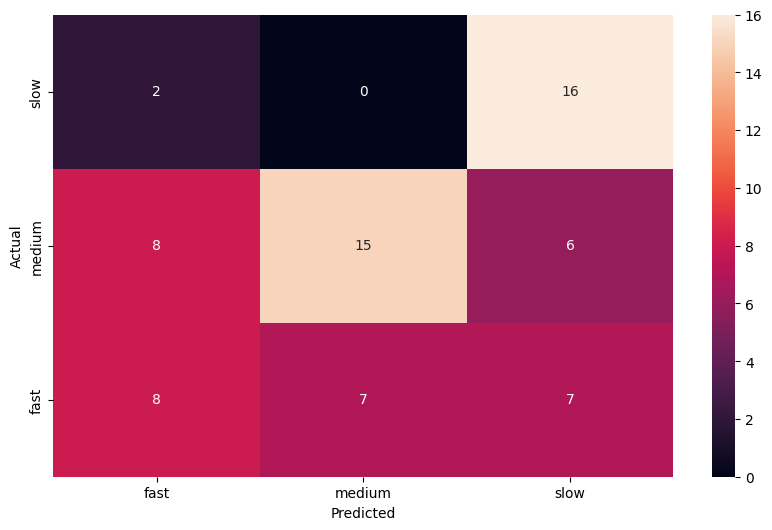

In [12]:
# Naive Bayes
# TODO: Move corr map to data viz section + discuss suitability of NB model

# load dataset 
nb_df = pd.read_csv('f1.csv')
nb_df1 = nb_df.loc[:,'Qualifying Time':'DRSMean']
nb_df1 = nb_df1.dropna()

# ---quality correlation matrix---
k = 8 # number of variables for heatmap
cols = nb_df1.corr().nlargest(k, 'Qualifying Time')['Qualifying Time'].index #change QT 
cm = nb_df1[cols].corr()
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm, annot=True, cmap = 'viridis')

# ---naive bayes classifier---
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# dividing data
nb_df1_features = nb_df1.drop(['Qualifying Time'], axis=1)
nb_df1_label_cat = pd.qcut(nb_df1.loc[:,'Qualifying Time'], q=3, labels=['slow','medium','fast'])
X_train, X_test, y_train, y_test = train_test_split(nb_df1_features, nb_df1_label_cat, 
                                                    train_size=0.8, test_size=0.2, random_state=0)

nb = GaussianNB() 
nb.fit(X_train, y_train)
y_test_pred = nb.predict(X_test)

#evaluate the classifier by score
print('Accuracy: ', metrics.accuracy_score(y_test, y_test_pred))

#evaluate the classifier by confusion matrix
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

### K Means


RMSE: 4.310083497262731
Optimal k (Corner): 19

RMSE: 5.657949484774946
Optimal k (Straight): 19


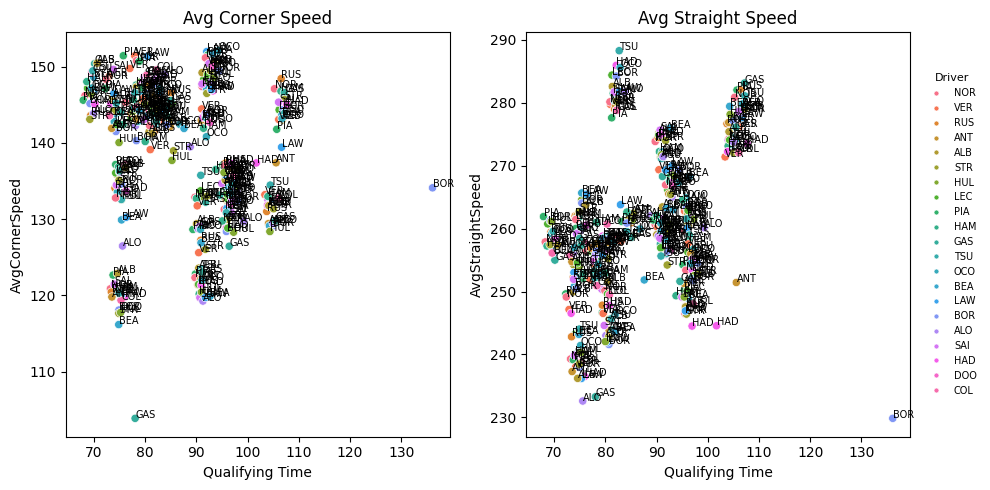

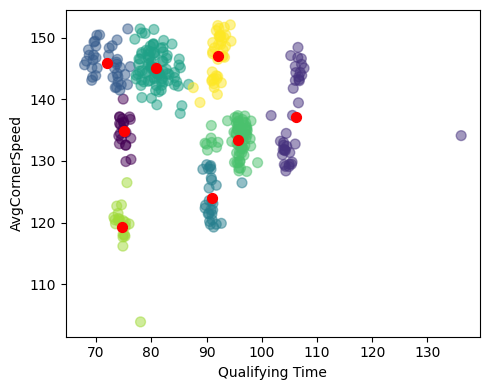

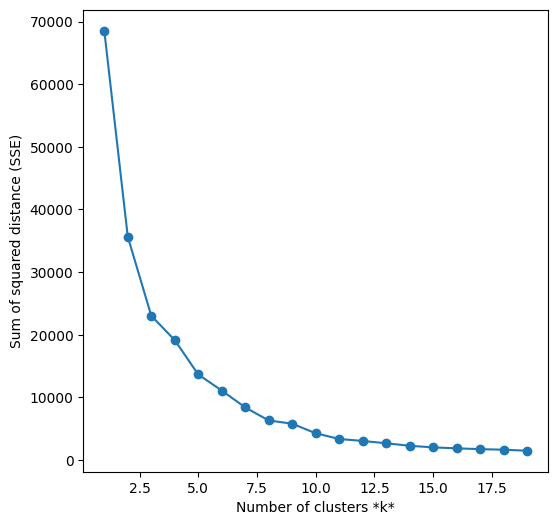

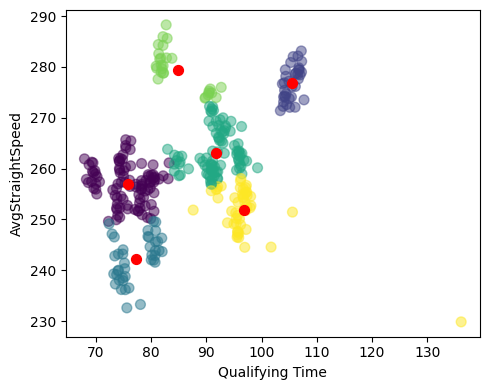

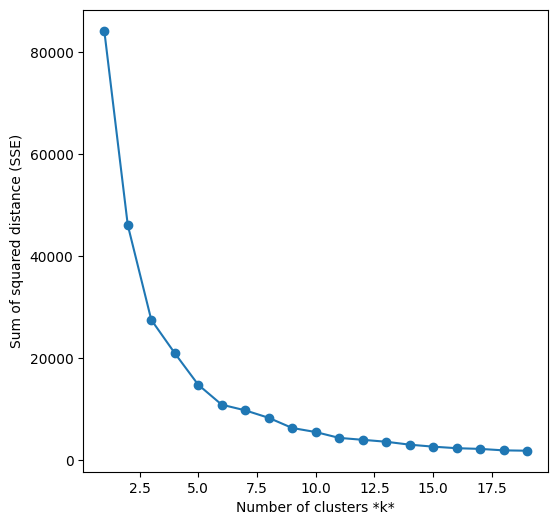

In [13]:
#k-means
from sklearn.cluster import KMeans

# load dataset 
kmeans_df = pd.read_csv('f1.csv')
kmeans_df = kmeans_df.dropna()

x = kmeans_df['Qualifying Time']
hue1 = kmeans_df['Driver']

# ----data exploration---
plt.figure(figsize=(10,5))
plot1 = plt.subplot(1,2,1)
sns.scatterplot(x=x, y=kmeans_df['AvgCornerSpeed'], hue=hue1) #Corner speed plot
plot1.set_title('Avg Corner Speed')
for i, driver in enumerate(kmeans_df['Driver']): #label for driver for their respective dot
    plot1.text(x.iloc[i]+0.05, kmeans_df['AvgCornerSpeed'].iloc[i]+0.05, driver, fontsize=7)

plot2 = plt.subplot(1,2,2)
sns.scatterplot(x=x, y=kmeans_df['AvgStraightSpeed'], hue=hue1) #Straight speed plot
plot2.set_title('Avg Straight Speed')
for i, driver in enumerate(kmeans_df['Driver']): #label for driver for their respective dot
    plot2.text(x.iloc[i]+0.05, kmeans_df['AvgStraightSpeed'].iloc[i]+0.05, driver, fontsize=7)

# making common legend
handles, labels = plt.gca().get_legend_handles_labels()
plot1.get_legend().remove()
plot2.get_legend().remove()
plt.legend(handles, labels, title='Driver', loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=7, title_fontsize=8, markerscale=0.6, frameon=False)

plt.tight_layout()

# ---apply k-means clustering (CORNER SPEED)---
features = ['Qualifying Time', 'AvgCornerSpeed']
X = kmeans_df[features]
print()

kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
rmse = np.sqrt(np.mean(squared_errors))
print("RMSE:", rmse)

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(kmeans_df['Qualifying Time'], kmeans_df['AvgCornerSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('Qualifying Time')
ax.set_ylabel('AvgCornerSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)');

# TODO: Get Correct Optimal K
optimal_k = list_k[np.argmin(sse)]
print(f"Optimal k (Corner): {optimal_k}")

# k = 6, RMSE: 0.6524419587814484
# k = 7, RMSE: 0.46647730684291305
# k = 8, RMSE: 0.4158006395544338
# Value of k = 8 is optimal for corner speed

# ---apply k-means clustering (STRAIGHT SPEED)---
features = ['Qualifying Time', 'AvgStraightSpeed']
X = kmeans_df[features]
print()

kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
rmse = np.sqrt(np.mean(squared_errors))
print("RMSE:", rmse)

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(kmeans_df['Qualifying Time'], kmeans_df['AvgStraightSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('Qualifying Time')
ax.set_ylabel('AvgStraightSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)')

# TODO: Get Correct Optimal K
optimal_k = list_k[np.argmin(sse)]
print(f"Optimal k (Straight): {optimal_k}")

# k = 4, RMSE: 0.7830298727862446
# k = 5, RMSE: 0.6561260588620095
# k = 6, RMSE: 0.5873858323437279
# Value of k = 6 is optimal for straight speed

### PCA

Explained variance ratio (all PCs): [0.35852579 0.20048319 0.13410943 0.1226571  0.10385573 0.05563011
 0.02010388 0.00463476]
Total variance (all PCs): 1.0000000000000002
Variance explained by PC1 and PC6: 0.4142


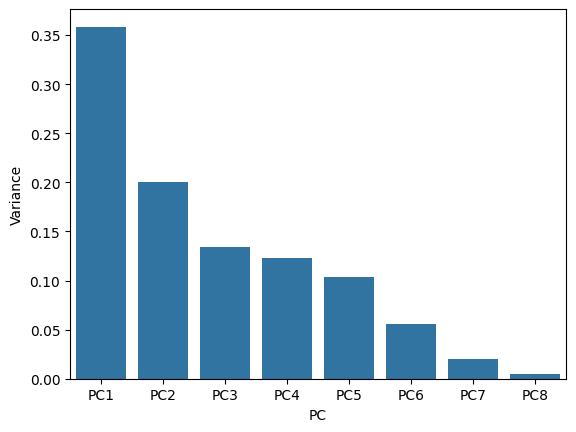

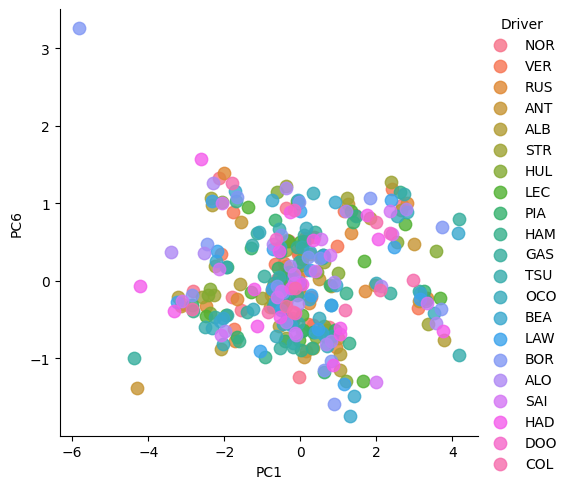

In [14]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
pca_df = pd.read_csv('./f1.csv')
pca_df = pca_df.dropna()
features = ['Top Speed','Qualifying Time','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
            'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

X = pca_df.loc[:, features].to_numpy() # Separating out the features
y = pca_df.loc[:,['Driver']].to_numpy() # Separating out the target
X = StandardScaler().fit_transform(X) # Standardizing the features

def plot_pca(pca_df, component_num=8, pc_x=1, pc_y=2):
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(X)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df['Driver'] = y.flatten()
        pc_df.head() #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df);

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        g = sns.lmplot( x=pcx, y=pcy,
        data=pc_df, 
        fit_reg=False, 
        hue='Driver', # color by cluster
        legend=True,
        scatter_kws={"s": 80}) # specify the point size

plot_pca(pca_df, component_num=8, pc_x=1, pc_y=6) #change pc_x and pc_y value to change PC view